# Authors - KHUBASHVILI Lasha, PATHAK Vaibhav, FEUNANG Billy, ATHEA Jules 
# [Weather data and solar radiation](01WeatherData.ipynb)

# [Thermal circuit and state-space representation for a thermal circuit with capacities in every node: simple wall](02SimpleWall.ipynb)

# Thermal circuit and state-space representation for a thermal circuit with capacities in some nodes: cubic building

**Objectives:**
- Analyse a cubic building with 2 identical walls & a transparent wall (glass window), air infiltration, and HVAC system controlling the indoor air temperature.
- Model the heat transfer in the building by a thermal circuit.
- Obtain the mathematical model as a system of Differential Algebraic Equations (DAE) from the thermal circuit.
- Transfrom the system of DAE into state-space representation.
- Find the steady-state solution.
- Simulate by using Euler methods for numerical integration..

In [709]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


## Physical analysis

### Description of the building


![cube](./figures/Screenshot 2023-05-30 111012.png)


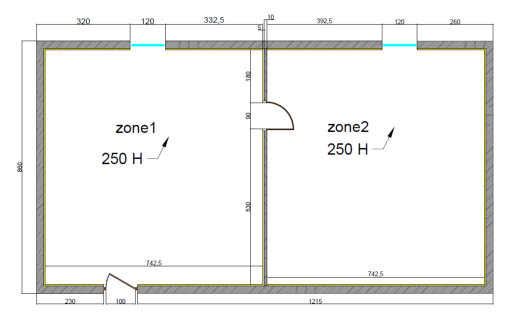

In [710]:
# Load and display the image
img = mpimg.imread('./figures/Screenshot 2023-05-30 111012.png')
imgplot = plt.imshow(img)
plt.axis('off')  # Turn off the axes
plt.show()

> Figure 1. Simple ventilated room (2 two-layer walls and 2 glass window) equiped with an HVAC system which acts as a proportional controller.

Let’s consider a cubic building with an HVAC systems acting as a [proportional controller](https://en.m.wikipedia.org/wiki/Proportional_control).

The dimensions and surface areas of the building are:
- $l=860 \: \mathrm{cm}$ - edge length of the cube;
- $S_g=l^2$   - surface area of the glass window;
- $S_c = S_i = 2 \times S_g$   - surface area of the 2 (concrete and insulation) walls.

In [711]:
l = 15.45               # m length of the cubic room
Sg = (1.20**2)*2           # m² surface of the 2 glass wall
Sc = Si = (2.5 * l*0.25) * 2   # m² surface of concrete & insulation of the 2 walls
#n=10
print (Sc)

19.3125


### Thermo-physical properties
The thermophysical properties of the air (in SI units) are:

In [712]:
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
# pd.DataFrame.from_dict(air, orient='index', columns=['air'])
pd.DataFrame(air, index=['Air'])

,Density,Specific heat
Air,1.2,1000


The [thermophysical properties](https://energieplus-lesite.be/donnees/enveloppe44/enveloppe2/conductivite-thermique-des-materiaux/) ([thermal conductivities](https://en.m.wikipedia.org/wiki/List_of_thermal_conductivities), [densities](https://en.wikipedia.org/wiki/Density) and [specific heat capacities](https://en.m.wikipedia.org/wiki/Table_of_specific_heat_capacities)) and the geometry (widths and surface areas) of the three materials (i.e., concrete, insulation, glass) in SI units are:

In [713]:
#tous les 10 au niveau des surfaces sont a supprimer, je voulais juste voir si ca marchait 

concrete1_2 = {'Conductivity': 1.400,
            'Density': 2300.0,
            'Specific heat': 880,
            'Width': 0.25,
            'Surface':16.3}   #wall1,wall2

concrete3 = {'Conductivity': 1.400,
            'Density': 2300.0,
            'Specific heat': 880,
            'Width': 0.25,
            'Surface':17.75}   #wallindoor

insulation1_2 = {'Conductivity': 0.04,
              'Density': 16.0,
              'Specific heat': 1210,
              'Width': 0.05,
              'Surface':16.3 }     #wall1,wall2


insulation3 = {'Conductivity': 0.04,
              'Density': 16.0,
              'Specific heat': 1210,
              'Width': 0.05,
              'Surface':  17.75}     #wallindoor (we change)

glass = {'Conductivity': 1.4,
         'Density': 2500,
         'Specific heat': 1210,
         'Width': 0.04,
         'Surface': 3}     #window1,window2

wood1 = {'Conductivity': 0.2,
         'Density': 2500,
         'Specific heat': 720,
         'Width': 0.05,
         'Surface': 2.5}     #door1

wood2 = {'Conductivity': 0.2,
         'Density': 2500,
         'Specific heat': 720,
         'Width': 0.05,
         'Surface':2.25 }     #indoor2

wall = pd.DataFrame.from_dict({'wall1_2' :concrete1_2, 'indwall' : concrete3, 'layerout1_2' : insulation1_2, 'layerout3' : insulation3, 'glass' : glass,
                              'door1' : wood1, 'inddoor' : wood2},
                              orient='index')

"""
controller1 = pd.DataFrame.from_dict({},
                              orient='index')

controller2 = pd.DataFrame.from_dict({},
                              orient='index')

ventilation = pd.DataFrame.from_dict({},
                              orient='index')
"""

wall

,Conductivity,Density,Specific heat,Width,Surface
wall1_2,1.40,2300.0,880,0.25,16.30
indwall,1.40,2300.0,880,0.25,17.75
layerout1_2,0.04,16.0,1210,0.05,16.30
layerout3,0.04,16.0,1210,0.05,17.75
glass,1.40,2500.0,1210,0.04,3.00
door1,0.20,2500.0,720,0.05,2.50
inddoor,0.20,2500.0,720,0.05,2.25


### Radiative properties

The [radiative properties](https://en.wikipedia.org/wiki/Emissivity#Absorptivity) of the surfaces are:
- long wave [emmisivity](https://www.engineeringtoolbox.com/emissivity-coefficients-d_447.html) of concrete (between normal and rough) and glass pyrex;
- short wave [absortivity of solar radiation](https://www.engineeringtoolbox.com/solar-radiation-absorbed-materials-d_1568.html) of white smooth surfaces;
- short wave [transmittance](https://www.engineeringtoolbox.com/optical-properties-glazing-materials-d_1355.html) of window glass (thickness of 4 mm);
- short wave [absortivity and transmittance](https://energieplus-lesite.be/techniques/enveloppe7/composants-de-l-enveloppe/vitrages/vitrage-permettant-le-controle-solaire/) of reflective blue window glass.

In [714]:
# radiative properties
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass

The [Stefan-Boltzmann constant](https://en.m.wikipedia.org/wiki/Stefan–Boltzmann_constant) is:

In [715]:
σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant
print(f'σ = {σ} W/(m²⋅K⁴)')

σ = 5.67e-08 W/(m²⋅K⁴)


### Convection coefficients

Conventional values for the [convection coeficients](https://energieplus-lesite.be/theories/enveloppe9/echanges-chaleur-parois/resistance-thermique-d-echange-superficiel/) for indoor and outdoor convection in W/(m²⋅K) are:

In [716]:
h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)
# h = pd.DataFrame([{'in': 8., 'out': 25}])  # W/(m²⋅K)

In [717]:
h


,in,out
h,8.0,25


## Thermal circuit

Heat transfert is:
- through the walls (concrete and insulation), 
- through the glass window,
- by ventilation,
- from indoor auxiliary sources,
- from the HVAC system.

The HVAC system is modelled as a proportional controller. There is long wave radiative exchange between the wall and the glass window. The sources are:
- temperature sources:
    - outdoor atmospheric air;
    - indoor air temperature setpoint;
- flow rate sources:
    - solar radiation on the outdoor and the indoor walls;
    - auxiliary heat gains in the thermal zone.

![heat_processes](./figures/03_heat_process.svg)
> Figure 2. Heat processes for the cubic building shown in Figure 1.

![thermal_circuit](./figures/03_therm_circ.svg)
> Figure 3. Thermal circuit for the cubic building shown in Figure 1 and the heat processes shown in Figure 2. *Note*: space discretization of the walls is done for simplicity.

Figure 3 shows the models of:
- concrete & insulation wall: in red;
- glass window: in green;
- ventilation: in magenta;
- indoor volume: in blue (conductances 6 & 7 for convection; conductance 5 for long wave radiation between the walls and the glass window);
- HVAC system: in black.

The sources are:
- $T_o$ - outdoor temperature, °C;
- $T_{i,sp}$ - setpoint temperaure for the indoor air, °C;
- $\Phi_o$ - solar radiation absorbed by the outdoor surface of the wall, W;
- $\Phi_i$ - solar radiation absorbed by the indoor surface of the wall, W;
- $\dot{Q}_a$ - auxiliary heat gains (i.e., occupants, electrical devices, etc.), W;
- $\Phi_a$ - solar radiation absorbed by the glass, W.


*Note*: The known values, i.e. the elements of the circuit (the conductances $G$ and capacities $C$) and the sources (of temperature $T$ and of flow rate $\Phi$ or $\dot{Q}$) are noted in uppercase (majuscule) letters. The unknow variables, i.e. the temperatures in the nodes $\theta$ and the flow rates on the branches $q$, are noted in lowercase (minuscule) letters.

### Thermal coductances
#### Conduction
The conductances 1, 2, 3, and 4 of the thermal circuit from Figure 3 model the heat transfer by [conduction](https://en.m.wikipedia.org/wiki/Thermal_conduction). Conduction conductances, in W/K, are of the form:
$$G_{cd} = \frac{\lambda}{w}S$$
where:

- $\lambda$ - [thermal conductvity](https://en.m.wikipedia.org/wiki/Thermal_conductivity), W/(m⋅K);
- $w$ - width of the material, m;
- $S$ - surface area of the wall, m².

In [718]:
# conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
pd.DataFrame(G_cd, columns=['Conduction'])



,Conduction
wall1_2,91.28
indwall,99.40
layerout1_2,13.04
layerout3,14.20
glass,105.00
door1,10.00
inddoor,9.00


#### Convection
The conductances 0, 6 and 7 model the heat transfer by [convection](https://en.m.wikipedia.org/wiki/Convection_(heat_transfer). Convection conductances, in W/K, are of the form:
$$G_{cv} = {h S}$$
where:
- $h$ is the [convection coefficient](https://en.m.wikipedia.org/wiki/Heat_transfer_coefficient), W/(m²⋅K);
- $S$ - surface area of the wall, m². 

In [719]:
# convection
Gcv_in = h['in'][0]* wall['Surface']    
Gcv_out = h['out'][0] * wall['Surface']     

Gcv = { 'Gcv_in' : Gcv_in, 'Gcv_out' : Gcv_out}
df = pd.DataFrame.from_dict(Gcv, orient='columns')
print(df)

print(Gcv_out['wall1_2'])




             Gcv_in  Gcv_out
wall1_2       130.4   407.50
indwall       142.0   443.75
layerout1_2   130.4   407.50
layerout3     142.0   443.75
glass          24.0    75.00
door1          20.0    62.50
inddoor        18.0    56.25
407.5


#### Long wave radiation
##### View factors inside the building

The majority of methods used for modelling the [radiative heat exchange](https://en.m.wikipedia.org/wiki/Thermal_radiation) use the [view factors](https://en.m.wikipedia.org/wiki/View_factor) between surfaces. The view factor $F_{i,j}$ is defined as *the proportion of radiation leaving surface $i$ that is intercepted by surface $j$*. The view factors can be estimated by [differential areas](https://en.m.wikipedia.org/wiki/View_factor#View_factors_of_differential_areas) or for different configurations of surfaces [[5](http://www.thermalradiation.net/indexCat.html)].

The view factors need to satisfy the [summation rule](https://en.m.wikipedia.org/wiki/View_factor#Summation_of_view_factors) 
$$\sum_{j=0}^{n-1} F_{i,j} = 1$$
and the [reciprocity theorem](https://en.wikipedia.org/wiki/View_factor#Reciprocity):
$$F_{i,j} S_i = F_{j,i} S_j$$
where $S_{i}$ and $S_{j}$ are the surface areas.

For a [convex](https://en.m.wikipedia.org/wiki/Convex_function) surface $i$, the [self-viewing factor](https://en.wikipedia.org/wiki/View_factor#Self-viewing_surfaces) is zero,
$$F_{i,i} = 0$$

Two simplified relations are used to calculate the view factors for buildings.

In the first one, the view factors are defined by:
$$\begin{cases}
F_{i,j} = \frac{S_i}{S_T}\\ 
F_{i,i} = 0
\end{cases}$$

where $S_{T} = \sum_{j=0}^{n-1} S_j$, i.e. the surface $S_j$ is included in the total surface $S_T$. In this method, the reciprocity theorem is satisfied,
$$F_{i,j} S_i = F_{j,i} S_j = \frac{S_i S_j}{S_T}$$
but summation rule isn't,
$$\sum_{j=0}^{n-1} F_{i,j} = \sum_{j=0, j \neq i}^{n-1} \frac{S_j}{S_T} = \frac {S_T - S_i}{S_T} \neq 1$$

In this case, the heat balance for each surface would be wrong.

In the second one, the view factors are defined by:
$$\begin{cases}
F_{i,j} = \frac{S_j}{S_T -S_i}\\ 
F_{i,i} = 0
\end{cases}$$

where $S_{T} = \sum_{j=0}^{n-1} S_j$, i.e. the surface $S_i$ is not included in the total surface $S_{T,i} = S_T - S_i$. 

In this case, the reciprocty theorem is generally not respected:
$$F_{i, j} S_i = \frac{S_j}{S_T - S_i} S_i \neq F_{j, i} S_j = \frac{S_i}{S_T - S_j} S_j$$
but the summation rule is respected:
$$ \sum_{i=0}^{n-1} F_{i, j} = \frac{1}{S_T - S_i} \sum_{\substack{j=0\\i\neq j}}^{n-1} S_j = 1 $$

In [720]:
# view factor wall-glass
Fwg1_2 = glass['Surface'] / concrete1_2['Surface']
Fwg3=glass['Surface'] / concrete3['Surface']

Fwg = { 'Fwg1_2' : Fwg1_2, 'Fwg3' : Fwg3}
df = pd.DataFrame.from_dict(Fwg, orient='index')
print(df)


               0
Fwg1_2  0.184049
Fwg3    0.169014


Note: The view factor between two surfaces, $j,k$ that are in the same plan (e.g. a window and a wall) is zero,
$$F_{j,k} = F_{k,j}=0$$

Therefore the total surface $S_{T,i}$ should be:
$$S_{T,i} = \sum_{j=0}^{n-1} S_j - \sum_k S_k$$
i.e. the surfaces $S_k$ in the same plan with the surface $S_i$ are not included in $S_{T,i}$.

##### View factor between tilted outdoor walls and sky

The view factor between the top surface of finite wall $w$ tilted relative to an infinite plane of the ground $g$ is [[5](http://www.thermalradiation.net/sectionc/C-9.html), [6](http://www.diva-portal.org/smash/get/diva2:1305017/FULLTEXT01.pdf), eq. 4.18]:

$$ F_{w,g} = \frac {1 - \cos \beta}{2}$$

Therefore, the view factor between the tilted wall $w$ and the sky dome $s$ is [[6](http://www.diva-portal.org/smash/get/diva2:1305017/FULLTEXT01.pdf), eq. 4.17]:
$$ F_{w,s} = 1 - F_{w,g} = \frac {1 + \cos \beta}{2}$$

##### Thermal network for long wave radiation

The long-wave heat exchange between surfaces may be modelled by using the concept of [radiosity](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)) and then linearizing the radiative heat exchange. 

![LW_rad_excg](./figures/03_LW_rad_excg.svg)
> Figure 4. Radiative long-wave heat exchange between two surfaces: a) modeled by [emmitance](https://en.m.wikipedia.org/wiki/Radiant_exitance) (source) and [radiosity](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)) (nodes); b) modeled by linearization of emmitance (temperature sources) and radiosity (temperature nodes).

For two surfaces, shown by temperature nodes 4 and 5 in Figure 3 and by nodes 1 and 2 in Figure 4, the [conductances](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)#Circuit_analogy), in m², for radiative heat exchange expressed by using the emmitance (or the [radiant excitance](https://en.m.wikipedia.org/wiki/Radiant_exitance))  of the black body, the [radiosity](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)), and the [reciprocity](https://en.m.wikipedia.org/wiki/View_factor#Reciprocity) of view factors are:

$$G_{1}^{r} = \frac{\varepsilon_1}{1 - \varepsilon_1} S_1$$

$$G_{1,2}^{r} = F_{1,2} S_1 = F_{2,1} S_2$$

$$G_{2}^{r} = \frac{\varepsilon_2}{1 - \varepsilon_2} S_2$$

where:
- $\varepsilon_1$ and $\varepsilon_2$ are the [emmisivities](https://en.m.wikipedia.org/wiki/Emissivity) of the surfaces 1 and 2;
- $S_1$ and $S_2$ - areas of the surfaces 1 and 2, m²;
- $F_{1,2}$ - [view factor](https://en.m.wikipedia.org/wiki/View_factor) between surfaces 1 and 2.


The [net flows leaving the surfaces 1 and 2](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)#Circuit_analogy) are:

$$q_{net,1} = \frac{\varepsilon_1}{1 - \varepsilon_1} S_1 (M^o_1 - J_1)= G^r_1 (M_1^o - J_1)$$

$$q_{net,2} = \frac{\varepsilon_2}{1 - \varepsilon_2} S_2 (M^o_2 - J_2)= G^r_2 (M_2^o - J_2)$$

respectively, where:
- $M^o_1$ and $M^o_2$ are the [emmitances](https://en.m.wikipedia.org/wiki/Radiant_exitance) of the surfaces 1 and 2 when emmiting as black bodies, $M^o = \sigma T^4$, W/m²;
- $J_1$ and $J_2$ - [radiosities](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)) of surfaces 1 and 2, W/m²;
- $G^r_1$ and $G^r_2$ - conductances for long wave radiative heat exchange, m².

The [net flow between surfaces 1 and 2](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)#Circuit_analogy) is:

$$q_{1,2} = F_{1,2} S_1 (J_1 - J_2) = F_{2,1} S_2 (J_1 - J_2)= G_{1,2}^r (J_1 - J_2)$$

In order to express the long-wave radiative exchange as a function of temperature differences, a linearization of the difference of temperatures $T_1^4 - T_2^4$ may be used:

$$T_1^4 - T_2^4 = (T_1^2 + T_2^2)(T_1^2 - T_2^2) = (T_1^2 + T_2^2)(T_1 + T_2)(T_1 - T_2) = 4 \bar{T}^3 (T_1 - T_2)$$

where the mean temperature $\bar{T}$, measured in kelvin, is:

$$\bar{T} =\sqrt[3]{ \frac{(T_1^2 + T_2^2)(T_1 + T_2)}{4}}$$

The evaluation of mean temperaure, $\bar{T}$, requires the values of the surface tempetratures, $T_1$ and $T_2$. An initial guess can be used (and then an iterative process, for a more precise evaluation).

After linearization, the conductances, in W/K, for radiative heat exchange are:

$$G_{1} = 4 \sigma \bar{T}^3 \frac{\varepsilon_1}{1 - \varepsilon_1} S_1$$

$$G_{1,2} = 4 \sigma \bar{T}^3 F_{1,2} S_1 = 4 \sigma \bar{T}^3 F_{2,1} S_2$$

$$G_{2} = 4 \sigma \bar{T}^3 \frac{\varepsilon_2}{1 - \varepsilon_2} S_2$$

In [721]:
# long wave radiation
Tm = 20 + 273   # K, mean temp for radiative exchange
#wall1_2
GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']['wall1_2']
GLW12 = 4 * σ * Tm**3 * Fwg1_2 * wall['Surface']['wall1_2']
GLWG = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall['Surface']['glass']

#indwall
GLWIND = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']['indwall']
GLWINDG = 4 * σ * Tm**3 * Fwg3 * wall['Surface']['indwall']


The equivalent conductance, in W/K, for the radiative long-wave heat exchange between the wall and the glass window is:
$$G = \frac{1}{1/G_1 + 1/G_{1,2} + 1/G_2}$$

In [722]:
GLW = 1 / (1 / GLW1 + 1 / GLW12 + 1 / GLWG)
GLWW = 1 / (1 / GLWIND + 1 / GLWINDG + 1 / GLWG)

print('long wave radiation wall1_2/glass =', GLW, 'W/K')
print('long wave radiation wall3/glass =', GLWW, 'W/K')

long wave radiation wall1_2/glass = 14.965687762200886 W/K
long wave radiation wall3/glass = 15.00049027455191 W/K


*Note*: Resistances in [series or parallel](https://en.m.wikipedia.org/wiki/Series_and_parallel_circuits) can be replaced by their equivalent resistance. 

#### Advection

The [volumetric flow rate](https://en.m.wikipedia.org/wiki/Volumetric_flow_rate) of the air, in m³/s, is:

$$\dot{V}_a = \frac{\mathrm{ACH}}{3600} V_a$$

where:
- $\mathrm{ACH}$  ([air changes per hour](https://en.m.wikipedia.org/wiki/Air_changes_per_hour)) is the air infiltration rate, 1/h;
- $3600$ - number of seconds in one hour, s/h;
- $V_a$ - volume of the air in the thermal zone, m³.

In [723]:
# ventilation flow rate
Va = 2*638*742.5*2.5                 # m³, volume of air, two rooms * L * l * h
ACH = 1                              # air changes per hour
Va_dot = (ACH / 3600) * Va           # m³/s, air infiltration
print('Va_dot=',Va_dot,'m^3')

Va_dot= 657.9375 m^3


The net flow rate that the building receives by [advection](https://en.m.wikipedia.org/wiki/Advection), i.e., introducing outdoor air at temperature $T_o$ and extracting indoor air at temperature $\theta_i$ by [ventilation](https://en.m.wikipedia.org/wiki/Ventilation_(architecture)) and/or [air infiltration](https://en.m.wikipedia.org/wiki/Infiltration_(HVAC)), is:

$$q_v = \dot{m}_a c_a (T_o - \theta_i) = \rho_a c_a \dot{V}_a (T_o - \theta_i)$$

where:
- $\dot{m}_a$ is the [mass flow rate](https://en.m.wikipedia.org/wiki/Mass_flow_rate) of air, kg/s;
- $\dot{V}_a$ - [volumetric flow rate](https://en.m.wikipedia.org/wiki/Volumetric_flow_rate), m³/s;
- $c_a$ - [specific heat capacity](https://en.m.wikipedia.org/wiki/Specific_heat_capacity) of the air, J/kg·K;
- $\rho_a$ - [density](https://en.m.wikipedia.org/wiki/Density) of air, kg/m³;
- $T_o$ - outdoor air temperature, °C (noted in majuscule because it is a *temperature source* or *input variable*);
- $\theta_i$ - indoor air temperature, °C (noted in minuscule because it is a *dependent temperature* or *output variable*).

Therefore, the conductance of [advection](https://en.m.wikipedia.org/wiki/Advection) by [ventilation](https://en.m.wikipedia.org/wiki/Ventilation_(architecture)) and/or [infiltration](https://en.m.wikipedia.org/wiki/Infiltration_(HVAC)), in W/K, is:

$$G_v = \rho_a c_a \dot{V}_a$$

In [724]:
# ventilation & advection
Gv = air['Density'] * air['Specific heat'] * Va_dot
Gv 

789525.0

> Table 1. Typical values for the ventilation rates (in air changes per hour, ACH) as a function of the position of windows (H. Recknagel, E. Spenger, E_R Schramek (2013), Table 1.12.1-4)

| Position of windows                     | Ventilation rate, ACH [h⁻ⁱ] |
| --------------------------------------- | ---------------------- |
| Window closed, doors closed             | 0 to 0.5 |
| Tilted window, venetian blind closed    | 0.3 to 1.5 |
| Tilted window, whitout venetian blind   | 0.8 to 4.0 |
| Window half opened                      | 5 to 10 |
| Window fully open                       | 9 to 15 |
| Window and French window fully open (cross ventilation) | about 40 |


#### Proportional controller

In the simplest representation, the [HVAC system](https://en.m.wikipedia.org/wiki/HVAC_control_system) can be considered as a [proportional controller](https://en.m.wikipedia.org/wiki/Proportional_control) that adjusts the heat flow rate $q_{HVAC}$ in order to control the indoor temperature $\theta_i$ at its setpoint value $T_{i,sp}$. The heat flow-rate, in W, injected by the [HVAC](https://en.m.wikipedia.org/wiki/Heating,_ventilation,_and_air_conditioning) system into the controlled space is:

$$ q_{HVAC} = K_p (T_{i, sp} - \theta_i)$$

where:
- $K_p$ is the proportional gain, W/K;
- $T_{i, sp}$ - indoor temperature [setpoint](https://en.m.wikipedia.org/wiki/Setpoint_(control_system)), °C (noted in majuscule because it is an *input, i.e. independent, variable*);
- $\theta_i$ - indoor temperature, °C (noted in minuscule because it is a *output, i.e. dependent variable*).

This equation shows that the proportional controller can be modelled by a source of temperature, $T_{i, sp}$, and a conductance, $K_p$. If the controller gain tends towards:
- infinity, $K_p \rightarrow \infty$, then the controller is perfect, $\theta_i \rightarrow T_{i, sp}$.
- zero, $K_p \rightarrow 0$, then the controller is not acting and the building is in free-running, i.e. $q_{HVAC} = 0$ ([Ghiaus 2003](https://doi.org/10.1016/S0378-7788(02)00110-X)).

*Note*: Respecting the [sign convention](https://en.m.wikipedia.org/wiki/Passive_sign_convention#Active_and_passive_components), the flow rate $q_{HVAC}$ is oriented from the lower to the higher potential of the temperature source $T_{i,sp}$.

In [725]:
# P-controler gain
Kp = 1e4            # almost perfect controller Kp -> ∞
#Kp = 1e-3           # no controller Kp -> 0
#Kp = 0

#### Conductances in series and/or parallel
If conductances are connected to temperature nodes which have no capacity and/or flow rate source, then the conductances can be considered in [series or parallel](https://en.m.wikipedia.org/wiki/Series_and_parallel_circuits) (depending on the connection). Let's consider, for example, the outdoor side of the glass window (Figure 3): the outdoor convection conductance and the conduction conductance (corresponding to half of the width of the glass) are in series:

$$ G_{gs} = \frac{1}{1/G_{g,cv.out } + 1/(2 G_{g,cd})} =  
\frac{1}{\frac{1}{h_{out} S_g} + \frac{w / 2}{\lambda S_g}}
$$

In [726]:
# glass: convection outdoor & conduction
#Ggs = float(1 / (1 /Gcv_out['out'] + 1 / (2 * G_cd['glass'])))

### Thermal capacities
#### Walls
The [thermal capacities](https://en.m.wikipedia.org/wiki/Heat_capacity) of the wall, in J/kg, are:

$$C_w= m_w c_w= \rho_w c_w w_w S_w$$

where:
- $m_w = \rho_w w_w S_w$ is the mass of the wall, kg;
- $c_w$ - [specific heat capacity](https://en.m.wikipedia.org/wiki/Specific_heat_capacity), J/(kg⋅K);
- $\rho_w$ - [density](https://en.m.wikipedia.org/wiki/Density), kg/m³;
- $w_w$ - width of the wall, m;
- $S_w$ - surface area of the wall, m².

In [727]:
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
pd.DataFrame(C, columns=['Thermal capacity'])

,Thermal capacity
wall1_2,8247800.0
indwall,8981500.0
layerout1_2,15778.4
layerout3,17182.0
glass,363000.0
door1,225000.0
inddoor,202500.0


In [728]:
C

wall1_2        8247800.0
indwall        8981500.0
layerout1_2      15778.4
layerout3        17182.0
glass           363000.0
door1           225000.0
inddoor         202500.0
dtype: float64

#### Air
Similarly, the thermal capacity of the air, in J/kg, is:

$$C_a = m_a c_a = \rho_a c_a V_a$$

where:
- $m_a = \rho_a V_a$ is the mass of the air, kg;
- $\rho_w$ - [density](https://en.m.wikipedia.org/wiki/Density) of air, kg/m³;
- $c_a$ - specific heat capacity of the air, J/(kg⋅K);
- $V_a$ - volume of the air in the thermal zone, m³.

In [729]:
C['Air'] = air['Density'] * air['Specific heat'] * Va
pd.DataFrame(C, columns=['Air Capacity'])

,Air Capacity
wall1_2,8.247800e+06
indwall,8.981500e+06
layerout1_2,1.577840e+04
layerout3,1.718200e+04
glass,3.630000e+05
door1,2.250000e+05
inddoor,2.025000e+05
Air,2.842290e+09


### Temperature sources

The [temperature sources](https://en.m.wikipedia.org/wiki/Voltage_source#Ideal_voltage_sources) model temperatures which vary independently of what happens in the themal circuit; they are inputs of the physical model. Generally, the temperature sources are:
- outdoor air and ground temperature;
- temperature of adjacent spaces which have controlled temperature;
- setpoint temperature.

#### Outdoor air and ground temperature
The hourly values of outdoor temperatures can be obtained from weather data files downloadable from the [Repository of free climate data for building performance simulation](http://climate.onebuilding.org) or from [Weather data for EnergyPlus®](https://energyplus.net/weather) (see the tutorial on [Weather data and solar radiation](01WeatherData.ipynb)).

#### Adjacent spaces with controlled temperature

If the adjacent spaces are controlled by a HVAC system, it means that their temperature can be considered independent of the studied thermal zone(s); therefore, they can be modelled by a temperature source.

#### Setpoint temperature

[Setpoint](https://en.m.wikipedia.org/wiki/Setpoint_(control_system)) temperature does not depend on the heat transfer processes of the analyzed thermal zone. If the HVAC system can deliver the heat flow rate:

$$ q_{HVAC} = K_p (T_{i, sp} - \theta_i)$$

where:
- $K_p$ is the proportional gain, W/K;
- $T_{i, sp}$ - indoor temperature [setpoint](https://en.m.wikipedia.org/wiki/Setpoint_(control_system)), °C;
- $\theta_i$ - indoor temperature, °C,

then the setpoint for indoor temperature, $T_{i, sp}$, may be modelled by a source of temperature.

### Heat flow rate sources
The [heat flow rate sources](https://en.m.wikipedia.org/wiki/Current_source#Background) model flow rates which vary idependently of what happens in the themal circuit. They are inputs of the physical model. Generally, the heat flow rate sources are:
- solar radiation absorbed by the walls;
- internal auxiliary sources.

#### Solar radiation absorbed by the walls

The [direct](https://en.m.wikipedia.org/wiki/Direct_insolation), diffuse and reflected components of the [solar radiation](https://en.m.wikipedia.org/wiki/Solar_irradiance) on a tilted surface can be estimated from weather data by using the function `sol_rad_tilt_surf` from the module `dm4bem` (see the tutorial on [Weather data and solar radiation](../t01/t01ReadWeatherData.ipynb)).

##### External wall

The radiation absorbed by the outdoor surface of the wall is:

$$\Phi_o = \alpha_{w,SW} S_w E_{tot}$$

where:
- $\alpha_{w,SW}$ is the [absorptance](https://en.m.wikipedia.org/wiki/Absorptance) of the outdoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_w$ - surface area of the wall, m²;
- $E_{tot}$ - total [solar irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance) on the wall, W/m².



##### Internal walls

The total shortwave incident irradiance on the wall $i$, $E_i$, may be estimated as a function of the direct solar irradiance incident on the surface of the walls, $E_{i}^{o}$:

$$S_i E_i = S_i E_{i}^{o} + \sum_{j=1}^{n} F_{j,i} S_j \rho_j E_j$$

where:
- $S_i$ is the area of the surface of the wall $i$, m²;
- $E_i$ - total irradiance received directly and by multiple reflections on surface $i$, W/m²;
- $E_{i}^{o}$ - irradiance received directly from the sun on surface $i$, W/m²;
- $F_{j, i}$ - [view factor](https://en.m.wikipedia.org/wiki/View_factor) between surface $j$ and surface $i$, $0 ⩽ F_{j,i} ⩽ 1$;
- $\rho_j$ - [reflectance](https://en.m.wikipedia.org/wiki/Reflectance) of surface $j$, $0 ⩽ \rho_j ⩽ 1$.


By taking into account the [reciprocity](https://en.m.wikipedia.org/wiki/View_factor#Reciprocity) of the view factors: $S_i F_{i,j} = S_j F_{j,i}$, the set of previous equation becomes:

$$
\begin{bmatrix}
1 - \rho_1 F_{1,1} & - \rho_2 F_{1,2}     & ...  & - \rho_n F_{1,n}\\ 
- \rho_1 F_{2,1}   & 1 - \rho_2 F_{2,2}  & ...  & - \rho_n F_{2,n} \\ 
...                         & ...                            & ...  & ... \\ 
- \rho_1 F_{n,1}  & - \rho_2 F_{n,1}      & ... & 1 - \rho_n F_{n,n}
\end{bmatrix} \begin{bmatrix}
E_1\\ 
E_2\\ 
...\\ 
E_n
\end{bmatrix} = \begin{bmatrix}
E_{1}^{o}\\ 
E_{2}^{o}\\ 
...\\ 
E_{n}^{o}
\end{bmatrix}
$$

or

$$(I - \rho \circ F) E = E^o$$

The unknown total [irradiances](https://en.m.wikipedia.org/wiki/Irradiance) on walls, in W/m², are then

$$ E = (I - \rho \circ F)^{-1} E^o$$

where:

- the symbol $\circ$ represents the [Hadamard (or element-wise) product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices));

$I =\begin{bmatrix}
1 & 0 & ... & 0 \\ 
0 & 1 & ... & 0 \\ 
... & ... & ... & ...\\ 
0 & 0 & ... & 1 
\end{bmatrix}, $ is the [identity matrix](https://en.m.wikipedia.org/wiki/Identity_matrix);

$\rho = \begin{bmatrix}
\rho_1\\ 
\rho_2\\ 
...\\ 
\rho_n
\end{bmatrix}$ - vector of [reflectances](https://en.m.wikipedia.org/wiki/Reflectance), $0 \le \rho_{i,j} \le 1$;

$F = \begin{bmatrix}
F_{1,1} & F_{1,2} & ... & F_{1,n}\\ 
F_{2,1} & F_{2,2} & ... & F_{2,n} \\ 
... & ... & ... & ...\\ 
F_{n,1} & F_{n,2} & ... & F_{n,n}
\end{bmatrix}$ - matrix of [view factors](https://en.m.wikipedia.org/wiki/View_factor), $0 \le F_{i,j} \le 1$;

$E^o = \begin{bmatrix}
E_{1}^{o}\\ 
E_{2}^{o}\\ 
...\\ 
E_{n}^{o}
\end{bmatrix}$ - vector of [direct solar irradiances](https://en.m.wikipedia.org/wiki/Solar_irradiance), W/m²;

$E = \begin{bmatrix}
E_1\\ 
E_2\\ 
...\\ 
E_n
\end{bmatrix}$ - vector of unknown total irradiances, W/m².


The radiative short wave (i.e. solar) heat flow rate on each surface is:

$$ \Phi = S E $$

where:

$\Phi = \begin{bmatrix}
\Phi_1\\ 
\Phi_2\\ 
...\\ 
\Phi_n
\end{bmatrix}$ - vector of total heat flow rates due to solar radiation, W; 

$S =\begin{bmatrix}
S_1 & 0 & ... & 0 \\ 
0 & S_2 & ... & 0 \\ 
... & ... & ... & ...\\ 
0 & 0 & ... & S_n 
\end{bmatrix}$ - matrix of surface areas of walls $i$, m².

#### Internal sources

Internal flow rates are generated by occupants and by the electrical equipment (with values given for [offices](https://energieplus-lesite.be/theories/bilan-thermique44/charges-thermiques-internes-pour-les-bureaux/), [commercial spaces](https://energieplus-lesite.be/theories/bilan-thermique44/charges-thermiques-internes-pour-les-commerces/), etc.).

## System of algebraic-differential equations (DAE)

The analysis of a thermal circuit, or the direct problem ([Ghiaus 2022](https://hal.archives-ouvertes.fr/hal-03484064/document)), means to find the temperatures in the nodes, $\theta$, and the heat flows on the branches, $q$, i.e. to solve for $\theta$ and $q$ the system of [Differential-Algebraic Equations (DAE)](https://en.m.wikipedia.org/wiki/Differential-algebraic_system_of_equations) (Figures 3 and 4):

$$\left\{\begin{array}{ll}
C \dot{\theta} = -(A^T G A) \theta + A^T G b + f\\ 
q = G (-A \theta + b)
\end{array}\right.$$

where:
- $\theta$ is the temperature vector of size $n_\theta$ equal to the number of nodes;
- $q$ - heat flow vector of size $n_q$ equal to the number of branches;
- $A$ - [incidence matrix](https://en.m.wikipedia.org/wiki/Incidence_matrix) of size $n_q$ rows and $n_{\theta}$ columns, where $n_q$ is the number of flow branches and $n_{\theta}$  is the number of temperature nodes. It shows how the temperature nodes are connected by oriented branches of heat flows:
    - if flow *m* enters into node *n*, then the element (*m, n*) of the matrix $A$ is 1, i.e., $A_{m,n} = 1$;
    - if flow *m* exits from node *n*, then the element (*m, n*) of the matrix $A$ is -1, i.e., $A_{m,n} = -1$, ; 
    - if flow *m* is not connected to node *n*, then the element (*m, n*) of the matrix $A$ is 0, i.e., $A_{m,n} = 0$.

- $G$ - conductance diagonal matrix of size $n_q \times n_q$,  where $n_q$ is the number of flow branches: diagonal matrix containing the conductances. Each branch $k$ needs to contain a conductance $0 < G_{k,k} < \infty $. 

- $C$ - capacity diagonal matrix of size $n_θ \times n_θ$,  where $n_θ$ is the number of temperature nodes: diagonal matrix containing the capacities. If there is no capacity in the node *n*, then $C_{n, n} = 0$.

- $b$ - temperature source vector of size $n_q$: if there is no temperature source on the branch *m*, then $b_m = 0$.

- $f$ - heat flow source vector of size $n_θ$: if there is no heat flow source in the node *n*, then $f_n = 0$.

The resolution is first done for temperatures, $\theta$, by solving the equation
$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$
which, generally, is a system of differential-algebraic equations (DAE). Then, the heat flow rates are found from the equation
$$q = G (-A \theta + b)$$

![thermal_circuit](./figures/03_TCmatrices.svg)
> Figure 4. Matrices of the system of Differential-Algebraic Equations (DAE) 
\begin{aligned}
  &C \dot{\theta} = -(A^T G A) \theta + A^T G b + f \\
  &q = G (-A \theta + b)
\end{aligned}

### A: incidence matrix

The [incidence matrix](https://en.m.wikipedia.org/wiki/Incidence_matrix) is:

$A_{kl} = \begin{cases}\phantom{-}
0 & \text{if branch } q_k \text{ is not connected to node }  \theta_l \\ 
+1 & \text{if branch } q_k \text{ enters into node }  \theta_l\\ 
-1 & \text{if branch } q_k \text{ gets out of node }  \theta_l 
\end{cases}$

For the themal circuit shown in Figure 3,

$ A = \begin{cases}
A_{0,0} = 1\\ 
A_{1,0} = -1, A_{1,1} = 1\\ 
...\\
A_{11,6} = 1\\
\end{cases}$

In [730]:
A = np.zeros([24, 16])       # n° of branches X n° of nodes
A[0, 0] = 1                 # branch 0: -> node 0
A[1, 0], A[1, 1] = -1, 1    # branch 1: node 0 -> node 1
A[2, 1], A[2, 2] = -1, 1    # branch 2: node 1 -> node 2
A[3, 2], A[3, 3] = -1, 1    # branch 3: node 2 -> node 3
A[4, 3] = -1                # branch 4: node 3 -> node 4
A[5, 5] = 1                 # branch 5: node 4 -> node 5
A[6, 5], A[6, 6] = -1, 1    # branch 6: node 4 -> node 6
A[7, 6], A[7, 7] = -1, 1    # branch 7: node 5 -> node 6
A[8, 7], A[8, 8] = -1, 1    # branch 8: -> node 7
A[9, 9]= 1                  # branch 9: node 5 -> node 7
A[10, 9], A[10, 10] = -1, 1 # branch 10: -> node 6
A[11, 8], A[11, 10] = -1, 1 # branch 11: -> node 6
A[12, 10], A[12, 12] = -1, 1 #
A[13, 12], A[13, 13] = -1, 1
A[14, 13], A[14, 14] = -1, 1
A[15, 14], A[15, 15] = -1, 1
A[16, 11], A[16, 15] = 1, -1 
A[17, 4] = 1
A[18, 4], A[18, 11] = -1, 1
A[19, 11] = 1
A[20,10], A[20,11] = -1, 1
A[21, 10] = 1
A[22, 10] = 1
A[23, 11] = 1


# np.set_printoptions(suppress=False)
# pd.DataFrame(A)
print (A)

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1. 

### G: conductance matrix

The conductance matrix of the themal circuit shown in Figure 3 is diagonal:

$ G = \begin{cases}
G_{0,0} = G_{w,out} & \text{convection outside surface of the wall}\\ 
G_{1,1} = G_{2,2} = 2G_{cd,Layer\,out} & \text{conduction in half width of the outer layer}\\ 
G_{3,3} = G_{4,4} = 2G_{cd,Layer\,in} & \text{conduction in half width of the inner layer}\\ 
G_{5,5} = G_{LW} & \text{long-wave radiation walls - window}\\
G_{6,6} = G_{w,in} & \text{convection inside surface of the wall}\\
G_{7,7} = G_{g,in} & \text{convection inside surface of the glass}\\
G_{8,8} = G_{gs} & \text{convection outside surface of the glass}\\  & \text{and conduction in half width of the glass}\\
G_{9,9} = 2G_{cd,glass} & \text{conduction in half width of the glass}\\
G_{10,10} = G_v & \text{advection by ventilation}\\
G_{11,11} = K_p & \text{gain of proportional controller}
\end{cases}$

In [731]:

G = np.zeros([24, 24]) 
#wall1_2
a=b=1
G[0,0]=G[5,5]=Gcv_out['wall1_2']
G[1,1]=G[6,6]=G_cd['wall1_2']
G[2,2]=G[7,7]=1/(1/G_cd['layerout1_2'] + 1/G_cd['wall1_2'])
G[3,3]=G[8,8]=G_cd['layerout1_2']
G[4,4]=G[11,11]=Gcv_in['layerout1_2']

#indwall
G[12,12]=Gcv_in['indwall'] 
G[16,16]=Gcv_in['layerout3']   
G[15,15]=G_cd['layerout3']
G[13,13]=G_cd['indwall']
G[14,14]=1/(1/G_cd['layerout3'] + 1/G_cd['indwall'])


#windows

G[17,17]=G[9,9]=Gcv_out['glass']
G[18,18]=G[10,10]=G_cd['glass']

#door   i don t know how it is modelled, conduction or convection?
G[20,20] = Gv              # main door advaction Gcv_out
G[19,19] = Gv              # door between rooms Gcv_in

#ventilation
G[21,21] = Kp

#Controller
G[22,22] = Gv      # controller 1 
G[23,23] = Gv      # controller 2 

#where can i put de long wave radiation convection ?

print('G=',G)


# np.set_printoptions(precision=3, threshold=16, suppress=True)
# pd.set_option("display.precision", 1)
# pd.DataFrame(G)

G= [[4.07500e+02 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [0.00000e+00 9.12800e+01 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 1.14100e+01 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 0.00000e+00 1.30400e+01 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.0000

### C: capacity matrix

The capacity matrix of the themal circuit shown in Figure 3 is diagonal:

$ C = \begin{cases}
C_{1,1} = C_{Layer\,out} & \text{outer layer of the wall}\\ 
C_{3,3} = C_{Layer\,in} & \text{inner layer of the wall}\\ 
C_{6,6} = C_{Air} & \text{air of the room}\\ 
C_{7,7} = C_{Glass} & \text{glass of the windows}\\
\end{cases}$

The thermal capacities of the air and of the glass can be neglected or not.

In [732]:
Cmat=np.zeros([16,16])
Cmat[1,1]=Cmat[6,6]=C['wall1_2']
Cmat[2,2]=Cmat[7,7]=C['layerout1_2']
Cmat[14,14]=C['layerout3']
Cmat[13,13]=C['indwall']

print('Cmat=',Cmat)

# pd.set_option("display.precision", 3)
# pd.DataFrame(C)

Cmat= [[      0.        0.        0.        0.        0.        0.        0.
        0.        0.        0.        0.        0.        0.        0.
        0.        0. ]
 [      0.  8247800.        0.        0.        0.        0.        0.
        0.        0.        0.        0.        0.        0.        0.
        0.        0. ]
 [      0.        0.    15778.4       0.        0.        0.        0.
        0.        0.        0.        0.        0.        0.        0.
        0.        0. ]
 [      0.        0.        0.        0.        0.        0.        0.
        0.        0.        0.        0.        0.        0.        0.
        0.        0. ]
 [      0.        0.        0.        0.        0.        0.        0.
        0.        0.        0.        0.        0.        0.        0.
        0.        0. ]
 [      0.        0.        0.        0.        0.        0.        0.
        0.        0.        0.        0.        0.        0.        0.
        0.        0. ]
 [  

### b: temperature source vector

The vector of *temperature sources* is $b$, of size $n_q$, the number of branches (in this example 12). An element of the vector $b$ corresponding to a branch without a source is zero. If the flow in a source is from the low potential to the high potential of the source (i.e. from - to +), then the source is positive. If the flow rate in the temperature source is from high potential to low potential (i.e. from + to -), then the source is negative (see [passive sign convention](https://en.m.wikipedia.org/wiki/Passive_sign_convention)). 

For the thermal circuit shown in Figure 3,

$$b = [\begin{matrix}
T_o &0  &0  &0  &0  &0  &0  &0  &T_o  &0  &T_o  &T_{i,sp} 
\end{matrix}]^T$$

i.e. $b_0 = b_8 = b_{10} = T_o$ and $b_{11} = T_{i,sp}$ where:
- $T_o$ is the outdoor temperature, °C;
- $T_{i,sp}$ - set-point temperaure for the indoor air, °C.

Since the temperature sorces $T_o$ and $T_{i,sp}$ are [time series](https://en.m.wikipedia.org/wiki/Time_series), in vector $b$ the branches which contain temperature sources are designated by $1$ and the branches without any temeprature source by $0$.

In [733]:
b = np.zeros(24)        # branches
b[[0, 5, 9, 17, 19, 21, 22, 23]] = 1   # branches with temperature sources
print(f'b = ', b)

b =  [1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1.]


### f: heat flow source vector

The vector of *heat sources* is $f$, of size $n_{\theta}$, the number of nodes (in this example 8). An element of the vector $f$ corresponding to a node without a heat source is zero.

For the thermal circuit shown in Figure 3,

$$f = [\begin{matrix}
\Phi_o &0  &0  &0  &\Phi_i  &0  &\dot{Q_a} &\Phi_a 
\end{matrix}]^T$$

i.e. $f_0 = \Phi_o$, $f_4 = \Phi_i$, $f_6 = \dot{Q_a}$, and $f_7 = \Phi_a$, where:
- $\Phi_o$ - solar radiation absorbed by the outdoor surface of the wall, W;
- $\Phi_i$ - solar radiation absorbed by the indoor surface of the wall, W;
- $\dot{Q}_a$ - auxiliary heat gains (i.e., occupants, electrical devices, etc.), W;
- $\Phi_a$ - solar radiation absorbed by the glass, W.

Since the flow rate sorces $\Phi_o$, $\Phi_i$, $\dot{Q}_a$ and $\Phi_a$ are [time series](https://en.m.wikipedia.org/wiki/Time_series), in vector $f$ the nodes which contain flow rate sources are designated by $1$ and the  nodes without any flow rate source by $0$.

In [734]:
f = np.zeros(16)         # nodes
f[[0, 3, 4, 5, 8, 9, 12, 15]] = 1     # nodes with heat-flow sources
print(f'f = ', f)

f =  [1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1.]


### y: output vector

The vector of outputs is $y$, of size $n_{\theta}$, the number of nodes (in this example 8). The non-zero values of $y$ indicate the nodes which are the outputs of the model.

For the thermal circuit shown in Figure 3, if the output is the indoor air temperature, then the output vector is:

$$y = [\begin{matrix}
0  &0  &0  &0  &0  &0  &\theta_6 &0 
\end{matrix}]^T$$

In vector $y$, the nodes for which the temperatures are outputs are noted by $1$ and the other nodes by $0$.

In [735]:
y = np.zeros(16)         # nodes
y[[11, 10 ]] = 1              # nodes (temperatures) of interest
print(f'y = ', y)

y =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]


## State-space representation
The [differential-algebraic system of equations (DAE)](https://en.m.wikipedia.org/wiki/Differential-algebraic_system_of_equations)

$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$

is transformed in [state-space representation](https://en.m.wikipedia.org/wiki/State-space_representation) ([Ghiaus 2013](https://hal.archives-ouvertes.fr/hal-03605823/document)):

$$\left\{\begin{array}{rr}
\dot{\theta}_s=A_s \theta_C + B_s u\\ 
y = C_s \theta_s + D_s u
\end{array}\right.$$

where:
- $\theta_s$ is the vector of state variables which are the temperatures of nodes containing capacities; the elements are in the same order as in the vector of temperatures, $\theta$; its dimension, $\dim \theta_s$, is equal to the number of capacities from the thermal network; for the circuit presented in Figure 3, $\theta_s = [\theta_1, \theta_3, \theta_6, \theta_7]^T$;

- $u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$ - vector of inputs of dimension $\dim u$ equal to the number of sources (of temperaure and heat flows) of the thermal network, where:

    - vector $b_T$ of nonzero elements of vector $b$ of temperature sources; for the circuit presented in Figure 3, $b_T = [T_o, T_o, T_o, T_{i,sp}]^T$ corresponds to branches 0, 8, 10 and 11; 
    - vector $f_Q$ of nonzero elements of vector $f$ of flow sources; for the circuit presented in Figure 3, $f_Q = [\Phi_o, \Phi_i, \dot{Q}_a, \Phi_a]^T$ corresponds to nodes 0, 4, 6, and 7;
    
- $y$ - vector of outputs is a subset of vector $\theta$ representing temperature nodes which are of interest; for the circuit presented in Figure 3, $y = \theta_6$, the indoor temperature.

- $A_s$ - state matrix, of dimension $\dim A_s = \dim {\theta_s} \times \dim {\theta_s}$;

- $B_s$ - input matrix, of dimension $\dim B_s = \dim {\theta_s} \times \dim u$;

- $C_s$ - output matrix, of dimension $\dim C_s = \dim y \times \dim {\theta_s}$;

- $D_s$ - feedthrough (or feedforward) matrix, of dimension $\dim D_s = \dim y \times \dim u$.

*Note*: The subscript $s$ of the matrices $A_s, B_s, C_s, D_s$ is used to differentiante the matrices $A_s, C_s$ of the state-space represenation of the matrices $A, C$ of the system of DAE.

The [state-space representation](https://en.m.wikipedia.org/wiki/State-space_representation), i.e., matrices $A_s, B_s, C_s, D_s$ is obtained from the system of DAE, i.e., matrices and vectors $A, G, b, C, f, y$ ([Ghiaus 2013](https://hal.archives-ouvertes.fr/hal-03605823/document)).

In [736]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, Cmat, f, y)
print('As = \n', As, '\n')
print('Bs = \n', Bs, '\n')
print('Cs = \n', Cs, '\n')
print('Ds = \n', Ds, '\n')


As = 
 [[-1.04252241e-05  1.38339921e-06  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 7.23140496e-04 -1.47445530e-03  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.04252241e-05  1.38339921e-06
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  7.23140496e-04 -1.47444858e-03
   3.31296921e-08  2.43805755e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.82011394e-11
  -7.89322607e-06  1.38342034e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.23889228e-09
   7.23151539e-04 -1.47445039e-03]] 

Bs = 
 [[9.04182490e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.21885274e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.

## Steady-state
[Steady-state](https://en.m.wikipedia.org/wiki/Steady_state) means that the term $C \dot \theta = 0$ in the system of DAE.

In [steady-state](https://en.m.wikipedia.org/wiki/Steady_state), the model can be checked if it is incorrect. Let's consider that:
- the controller is not active, $K_p \rightarrow 0$,
- the outdoor temperature is $T_o = 10 \, \mathrm{^\circ C}$,
- the indoor temperature setpoint is $T_{i,sp} = 20 \, \mathrm{^\circ C}$,
- all flow rate sources are zero.

In [737]:
b = np.zeros(24)        # temperature sources
b[[0, 5, 9, 17, 19]] = 10      # outdoor temperature
b[[21, 22, 23]] = 20            # indoor set-point temperature

f = np.zeros(16)         # flow-rate sources
print(b)

[10.  0.  0.  0.  0. 10.  0.  0.  0. 10.  0.  0.  0.  0.  0.  0.  0. 10.
  0. 10.  0. 20. 20. 20.]


*Note*: Steady-state analysis is a test of [falsification (refutability)](https://en.m.wikipedia.org/wiki/Falsifiability) of the model, not a [verification and validation](https://en.m.wikipedia.org/wiki/Verification_and_validation). If the model does not pass the steady-state test, it means that it is wrong. If the model passes the steady-state test, it does not mean that it is correct. For example, the values of the capacities in matrix $C$ or of the conductances in matrix $G$ can be wrong even when the steady-state test is passed. 

### System of Diferential Algebraic Equations (DAE)
The value of temperature in [steady-state](https://en.m.wikipedia.org/wiki/Steady_state) is obtained from the system of DAE by considering that $C \dot{\theta} = 0$:

$$\theta_{ss} = (A^T G A)^{-1}(A^T G b + f)$$

For the conditions mentioned above, in steady-state, all temperatures $\theta_0 ... \theta_7$, including the indoor air temperature $\theta_6$, are equal to $T_o = 10 \, \mathrm{^\circ C}$.

In [738]:
θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print(f'θ = {θ} °C')

θ = [ 9.86764358  9.27676672  4.54975183  0.4136138  13.50279947 10.1060799
 10.5796509  14.36821884 17.6832158  14.6752507  18.01471549 16.0047991
 17.93385679 17.81834435 16.89424486 16.0856578 ] °C


### State-space representation
The input vector $u$ is obtained by stacking the vectors $b_T$ and $f_Q$:

$$u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$$

where:
- $b_T$ is a vector of the nonzero elements of vector $b$ of temperature sources. For the circuit presented in Figure 3, $b_T = [T_o, T_o, T_o, T_{i,sp}]^T$ corresponding to branches 0, 8, 10 and 11, where:
    - $T_o$ - outdoor temperature, °C;
    - $T_{i,sp}$ - set-point temperaure for the indoor air, °C.
- $f_Q$ - vector the nonzero elements of vector $f$ of flow sources. For the circuit presented in Figure 3, $f_Q = [\Phi_o, \Phi_i, \dot{Q}_a, \Phi_a]^T$ corresponding to nodes 0, 4, 6, and 7, where:
    - $\Phi_o$ - solar radiation absorbed by the outdoor surface of the wall, W;
    - $\Phi_i$ - solar radiation absorbed by the indoor surface of the wall, W;
    - $\dot{Q}_a$ - auxiliary heat gains (i.e., occupants, electrical devices, etc.), W;
    - $\Phi_a$ - solar radiation absorbed by the glass, W.

*Note*: Zero in vectors $b$ and $f$ indicates that there is no source on the branch or in the node, respectively. However, a source can have the value zero.

In [739]:
bT = np.array([10, 10, 10, 10, 10, 20, 20, 20])     # [To, To, To, Tisp]
fQ = np.array([0, 0, 0, 0, 0, 0, 0, 0])                         # [Φo, Φi, Qa, Φa]
u = np.hstack([bT, fQ])
print(f'u = {u}')

u = [10 10 10 10 10 20 20 20  0  0  0  0  0  0  0  0]


The steady-state value of the output of the state-space representation is obtained when $\dot \theta_{C} = 0$:

$$y_{ss} = (-C_s A_s^{-1} B_s + D_s) u$$

In [740]:
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
print(f'yss = {yss} °C')

yss = [18.01471549 16.0047991 ] °C


The error between the steady-state values obtained from the system of DAE, $\theta_6$, and the output of the state-space representation, $y_{ss}$, 

$$\varepsilon = \left | \theta_6 - y_{ss} \right |$$

is practically zero; the slight difference is due to [numerical errors](https://en.m.wikipedia.org/wiki/Numerical_error).

In [741]:
print(f'Max error between DAE and state-space: \
{max(abs(θ[11] - yss)):.2e} °C')

Max error between DAE and state-space: 2.01e+00 °C


## Dynamic simulation

### Time step

The condition for [numerical stability](https://en.m.wikipedia.org/wiki/Euler_method#Numerical_stability) of [Euler explicit integration](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) method is

$$\left |  \lambda_i \Delta t + 1 \right | < 1, \forall \lambda_i, $$

i.e. in the complex plane, $\lambda_i \Delta t$ is inside a circle of radius 1 centered in {-1, 0j}, where:
- $\lambda_i$ are the eigenvalues of matrix $A_s$,
- $\Delta t$ - time step.

For positive real eigenvalues $\left \{ \lambda \in \Re |\lambda >0  \right \}$, which is the case of thermal networks, the above condition [becomes](http://www.math.iit.edu/~fass/478578_Chapter_4.pdf)

$$- \lambda_i \Delta t - 1  < 1, \forall \lambda_i, $$

or

$$ 0 < \Delta t < -\frac{2}{\min \lambda_i} = 2 \min -\frac{1}{\lambda_i} = 2 \min T_i$$

where $T_i$ are the [time constants](https://en.m.wikipedia.org/wiki/Time_constant), $T_i = - \frac{1}{\lambda_i} $

In [742]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As

print('Time constants: \n', -1 / λ, 's \n')
print('2 x Time constants: \n', -2 / λ, 's \n')
dtmax = 2 * min(-1. / λ)
print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

Time constants: 
 [102645.91492629    677.90254341    677.906549      677.90440909
 102645.94790702 138669.60099354] s 

2 x Time constants: 
 [205291.82985258   1355.80508681   1355.81309801   1355.80881819
 205291.89581405 277339.20198708] s 

Maximum time step: 1355.81 s = 22.60 min


Let's chose a time step smaller than $\Delta t_{max} = \min (-2 / \lambda_i) $.

In [743]:
# time step
dt = np.floor(dtmax / 60) * 20   # s
print(f'dt = {dt} s = {dt / 60:.0f} min')

dt = 440.0 s = 7 min


### Settling time
The [settling time](https://en.m.wikipedia.org/wiki/Step_response) is roughly 4 times the larger time constant.

In [744]:
# settling time
time_const = np.array([int(x) for x in sorted(-1 / λ)])
print('4 * Time constants: \n', 4 * time_const, 's \n')

t_settle = 4 * max(-1 / λ)
print(f'Settling time: \
{t_settle:.0f} s = \
{t_settle / 60:.1f} min = \
{t_settle / (3600):.2f} h = \
{t_settle / (3600 * 24):.2f} days')

4 * Time constants: 
 [  2708   2708   2708 410580 410580 554676] s 

Settling time: 554678 s = 9244.6 min = 154.08 h = 6.42 days


### Step response
Let's obtain the dynamic response of the system to a [step input](https://en.m.wikipedia.org/wiki/Step_response).

#### Duration
The duration of the simulation needs to be larger than the estimated [settling time](https://en.m.wikipedia.org/wiki/Settling_time). This requires a corresponding number of time steps in the time vector.

In [745]:
# Step response
# -------------
# Find the next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
# pd.DataFrame(t, columns=['time'])

Duration = 558000.0 s
Number of time steps = 1268


#### Input vector
In dynamic simulation, the inputs are [time series](https://en.m.wikipedia.org/wiki/Time_series), e.g., the oudoor temperature will have $n$ values $T_o = [T_{o(0)}, T_{o(1)}, ..., T_{o(n-1)}]^T$ at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.

The input vector $u$ of the state-space representation is obtained by stacking the vectors $b_T$ and $f_Q$ of the system of Differential Algebraic Equations:

$$u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$$

where:
- vector $b_T$ consists of the nonzero elements of vector $b$ of temperature sources; for the circuit presented in Figure 3, 

$$b = [\begin{matrix}
T_o &0  &0  &0  &0  &0  &0  &0  &T_o  &0  &T_o  &T_{i,sp} 
\end{matrix}]^T$$
and 
$$b_T = [T_o, T_o, T_o, T_{i,sp}]^T$$
corresponding to branches 0, 8, 10 and 11; 
- vector $f_Q$ is the nonzero elements of vector $f$ of flow sources; for the circuit presented in Figure 3,

$$f = [\begin{matrix}
\Phi_o &0  &0  &0  &\Phi_i  &0  &\dot{Q_a} &\Phi_a 
\end{matrix}]^T$$

and

$$f_Q = [\Phi_o, \Phi_i, \dot{Q}_a, \Phi_a]^T$$

corresponding to nodes 0, 4, 6, and 7.

For the thermal circuit shown in Figure 3, the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the input vector, $u = [u_0, u_1, ... , u_{n-1}]^T$, is:

$$u = 
\begin{bmatrix}
T_o\\ 
T_o\\ 
T_o\\ 
T_{i,sp}\\ 
\Phi_o\\ 
\Phi_i\\ 
\dot{Q}_a\\ 
\Phi_a
\end{bmatrix}
= \begin{bmatrix}
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
 T_{i,sp(0)} & T_{i,sp(1)}& ... & T_{i,sp(n-1)}\ \\ 
\Phi_{o,(0)} & \Phi_{o,(1)} & ... & \Phi_{o,(n-1)}\\
\Phi_{i,(0)} & \Phi_{i,(1)} & ... & \Phi_{i,(n-1)}\\ 
 \dot{Q}_{a(0)} & \dot{Q}_{a(1)} & ... & \dot{Q}_{a(n-1)}\\ 
\Phi_{a,(0)} & \Phi_{a,(1)} & ... & \Phi_{a,(n-1)}
\end{bmatrix}$$

where:
- $T_o = [T_{o(0)}, T_{o(1)}, ..., T_{o(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the oudoor temperature at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $T_{i, sp} = [T_{{i, sp}(0)}, T_{{i, sp}(1)}, ..., T_{{i, sp}(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the setpoint indoor temperature at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $\Phi_o = [\Phi_{o(0)}, \Phi_{o(1)}, ..., \Phi_{o(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the solar radiation absorbed by the outdoor surface of the wall at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $\Phi_i = [\Phi_{i(0)}, \Phi_{i(1)}, ..., \Phi_{i(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the solar radiation absorbed by the indoor surface of the wall at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $\dot{Q}_a = [\dot{Q}_{a(0)}, \dot{Q}_{a(1)}, ..., \dot{Q}_{a(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the auxiliary heat gains (i.e., occupants, electrical devices, etc.) at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $\Phi_a = [\Phi_{a(0)}, \Phi_{a(1)}, ..., \Phi_{a(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the solar radiation absorbed by the glass at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.

Let's consider a step response in the conditions used for steady-state analysis, i.e. $T_o = 10 \, \mathrm{^\circ C}$, $T_{i,sp} = 20 \, \mathrm{^\circ C}$, and all the flow sources zero (including the HVAC system).

In [746]:
u = np.zeros([16, n])                # u = [To To To Tisp Φo Φi Qa Φa]
u[0:5, :] = 10 * np.ones([5, n])    # To = 10 for n time steps
u[5:8, :] = 20 * np.ones([3, n])      # Tisp = 20 for n time steps


pd.DataFrame(u)


,0,1,2,3,4,5,6,7,8,9,...,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267
0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
2,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
3,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
4,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
5,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
6,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
7,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Time integration

By integrating the state-space model

$$\left\{\begin{array}{rr}
\dot{\theta}_C=A_s \theta_C + B_s u\\ 
y = C_s \theta_C + D_s u
\end{array}\right.$$

by using [Euler forward (or explicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) for numerical integration:

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

and [Euler backward (or implicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method) for numerical integration:

$$\theta_{s,k+1} = (I - \Delta t A)^{-1} ( \theta_{s,k} + \Delta t B u_k )$$

where $k = 0, ... , n - 1$,

In [747]:
n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k] + dt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @ (θ_imp[:, k] + dt * Bs @ u[:, k])
    
print(θ_exp)

[[0.00000000e+00 3.97840296e-02 7.93855658e-02 ... 9.23627550e+00
  9.23644907e+00 9.23662189e+00]
 [0.00000000e+00 0.00000000e+00 1.26585549e-02 ... 4.52976099e+00
  4.52984668e+00 4.52993201e+00]
 [0.00000000e+00 3.97840296e-02 8.30103226e-02 ... 1.05334318e+01
  1.05336300e+01 1.05338272e+01]
 [0.00000000e+00 5.95495752e+00 8.05925742e+00 ... 1.43453925e+01
  1.43454904e+01 1.43455878e+01]
 [0.00000000e+00 5.15994785e-02 1.06240382e-01 ... 1.74983897e+01
  1.74994049e+01 1.75004169e+01]
 [0.00000000e+00 5.29070547e+00 7.16544666e+00 ... 1.67365502e+01
  1.67370506e+01 1.67375494e+01]]


we obtain the outputs

$$ y = C_s \theta_s + D_s u$$

for explicit and for implicit Euler methods, respectively.

In [748]:
y_exp = Cs @ θ_exp + Ds @  u
y_imp = Cs @ θ_imp + Ds @  u
#print('y_exp',y_exp)
print(np.shape(Cs))
print(np.shape(θ_exp))
print(np.shape(Ds))
print(np.shape(u))
print(np.shape(y_exp))


(2, 6)
(6, 1268)
(2, 16)
(16, 1268)
(2, 1268)


The results of explicit and implicit Euler integration are practically identical.

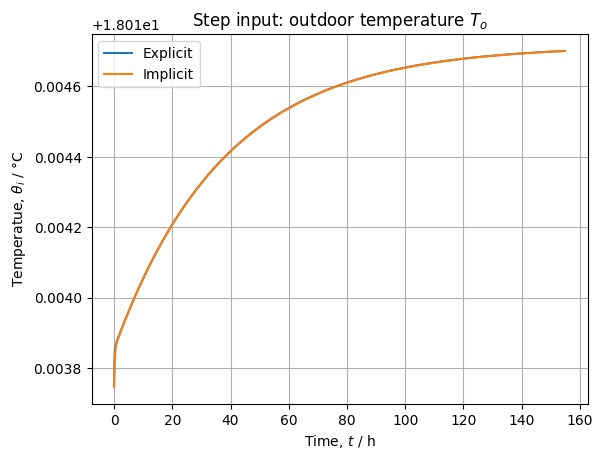

y_exp= [18.01374651 18.01381919 18.01384649 ... 18.01470067 18.01470072
 18.01470076]


In [749]:
fig, ax = plt.subplots()
ax.plot(t/3600, y_exp.T[:,0], t / 3600, y_imp.T[:,0])   
ax.set(xlabel='Time, $t$ / h',
       ylabel='Temperatue, $θ_i$ / °C',
       title='Step input: outdoor temperature $T_o$')
ax.legend(['Explicit', 'Implicit'])
ax.grid()
plt.show()
print('y_exp=', y_exp.T[:,0])   

> Figure 5. Step response to outdoor temperature by using Euler
[implicit](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method)
and
[explicit](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) integration.

The value the indoor temperature obtained after the [settling time](https://en.m.wikipedia.org/wiki/Settling_time) is almost equal to the value obtained in steady-state.

In [750]:
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: Room 1: {float(θ[11]):.4f}, Room 2: {float(θ[10]):.4f} °C')
print(f'- state-space model: Room 1: {float(yss[0]):.4f}, Room 2: {float(yss[1]):.4f} °C')
print(f'- steady-state response to step input: Room1: {float(y_exp[0, -2]):.4f}, Room2: {float(y_exp[1, -2]):.4f} °C')

Steady-state indoor temperature obtained with:
- DAE model: Room 1: 16.0048, Room 2: 18.0147 °C
- state-space model: Room 1: 18.0147, Room 2: 16.0048 °C
- steady-state response to step input: Room1: 18.0147, Room2: 16.0048 °C


### Simulation with weather data

#### Start and end time
The simulation will be done from `start_date` to `end_date` indicated in the format `MM-DD HH:MM:SS` (month, day, hour:minute:second).

In [751]:
start_date = '01-03 12:00:00'
end_date = '02-05 18:00:00'

The weather data are for a year. The choice of `2000` for the year is arbitrary; it used in order to respect the format `YYYY-MM-DD HH:MM:SS`.

In [752]:
start_date = '2000-' + start_date
end_date = '2000-' + end_date
print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

2000-01-03 12:00:00 	start date
2000-02-05 18:00:00 	end date


#### Inputs
##### Read weather data
Dynamic simulation needs [time series](https://en.m.wikipedia.org/wiki/Time_series) of weather data for air temperature, direct solar radiation on a normal surface and diffuse solar radiation on an horizontal surface (see the tutorial on [Weather data and solar radiation](../t01/t01ReadWeatherData.ipynb)).

In [753]:
filename = './weather_data/FRA_Lyon.074810_IWEC.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

From the weather data, we select:
- hourly outdoor air temperature, °C;
- hourly solar [direct normal irradiance](https://en.m.wikipedia.org/wiki/Direct_insolation) (or beam radiation), W/m²;
- hourly solar diffuse horizontal irradiance (or [diffuse sky radiation](https://en.wikipedia.org/wiki/Diffuse_sky_radiation)), W/m²,

from the start to the end date.

In [754]:
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]
print (weather)

                           temp_air  dir_n_rad  dif_h_rad
2000-01-03 12:00:00+01:00       6.8          6        133
2000-01-03 13:00:00+01:00       8.0         74        150
2000-01-03 14:00:00+01:00      10.0         90        135
2000-01-03 15:00:00+01:00       9.0         64         84
2000-01-03 16:00:00+01:00       8.0          0         19
...                             ...        ...        ...
2000-02-05 14:00:00+01:00      12.0        540        126
2000-02-05 15:00:00+01:00      12.0        383        109
2000-02-05 16:00:00+01:00      11.0        136         79
2000-02-05 17:00:00+01:00      10.0          0         12
2000-02-05 18:00:00+01:00       8.3          0          0

[799 rows x 3 columns]


##### Solar irradiance on the walls
For the surface orientation given by `slope`, `azimuth`and `latitude`, and the `albedo` of the surface in front of the wall, by using the weather data, we can calculate the:
- direct irradiance, W/m²,
- diffuse irradiance, W/m²,
- reflected irradiance, W/m²,

for hourly solar [irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance) on a tilted surface.

In [755]:
surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, albedo)
# pd.DataFrame(rad_surf)

The total solar [irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance)  $E_{tot}$, in W/m², is the sum of direct, diffuse, and reflected components.  

In [756]:
rad_surf['Φtot'] = rad_surf.sum(axis=1)
print(rad_surf)

                               direct  diffuse  reflected        Φtot
2000-01-03 12:00:00+01:00    5.423683     66.5  27.025936   98.949619
2000-01-03 13:00:00+01:00   62.074669     75.0  34.289730  171.364399
2000-01-03 14:00:00+01:00   66.175859     67.5  30.353167  164.029026
2000-01-03 15:00:00+01:00   38.420856     42.0  17.456968   97.877824
2000-01-03 16:00:00+01:00    0.000000      9.5   3.800000   13.300000
...                               ...      ...        ...         ...
2000-02-05 14:00:00+01:00  366.835007     63.0  55.437685  485.272692
2000-02-05 15:00:00+01:00  206.374750     54.5  32.485083  293.359833
2000-02-05 16:00:00+01:00   51.032277     39.5  15.800272  106.332549
2000-02-05 17:00:00+01:00    0.000000      6.0   2.400000    8.400000
2000-02-05 18:00:00+01:00    0.000000      0.0   0.000000    0.000000

[799 rows x 4 columns]


##### Resample the weather data
The weather data is at the time-step of 1h. It needs to be resampled at time step $\Delta t$ used for numerical integration.

In [757]:
# resample weather data
data = pd.concat([weather['temp_air'], rad_surf['Φtot']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})
pd.DataFrame(data)
#print(rad_surf)

,To,Φtot
2000-01-03 11:58:40+01:00,NaN,NaN
2000-01-03 12:06:00+01:00,NaN,NaN
2000-01-03 12:13:20+01:00,NaN,NaN
2000-01-03 12:20:40+01:00,NaN,NaN
2000-01-03 12:28:00+01:00,NaN,NaN
...,...,...
2000-02-05 17:28:40+01:00,11.0,599.32022
2000-02-05 17:36:00+01:00,11.0,599.32022
2000-02-05 17:43:20+01:00,11.0,599.32022
2000-02-05 17:50:40+01:00,11.0,599.32022


##### Other inputs
Let's consider the indoor temperature setpoint $T_{i,sp} = 20 \, \mathrm{^\circ C}$ and the auxiliary heat flow $\dot{Q}_a = 0 \, \mathrm{W}$ constant for the whole duration of the simulation.

In [758]:
data['Ti'] = 20 * np.ones(data.shape[0])
data['Qa'] = 0 * np.ones(data.shape[0])
# pd.DataFrame(data)

##### Input vector in time
The input is formed by the vectors of time series of temperature sources $\left [ T_o, T_o ,T_o, T_{i,sp} \right ]^T$ and vectors of time series of the heat flow sources $\left [ \Phi_o, \Phi_i, \dot{Q_a}, \Phi_a \right ]^T$:

$$u = 
\begin{bmatrix}
T_o\\ 
T_o\\ 
T_o\\ 
T_{i,sp}\\ 
\Phi_o\\ 
\Phi_i\\ 
\dot{Q}_a\\ 
\Phi_a
\end{bmatrix}
= \begin{bmatrix}
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
 T_{i,sp(0)} & T_{i,sp(1)}& ... & T_{i,sp(n-1)}\ \\ 
\Phi_{o,(0)} & \Phi_{o,(1)} & ... & \Phi_{o,(n-1)}\\
\Phi_{i,(0)} & \Phi_{i,(1)} & ... & \Phi_{i,(n-1)}\\ 
 \dot{Q}_{a(0)} & \dot{Q}_{a(1)} & ... & \dot{Q}_{a(n-1)}\\ 
\Phi_{a,(0)} & \Phi_{a,(1)} & ... & \Phi_{a,(n-1)}
\end{bmatrix}$$

where:

$T_o$: the time series vector of outdoor temperatures (from weather data), °C.

$T_{i,sp}$: time series vector of indoor setpoint temperatures, °C.

$\Phi_o$: time series vector of solar (i.e. short wave) radiation, in W, absorbed by the outdoor surface of the wall:

$$\Phi_o = \alpha_{w,SW} S_w E_{tot}$$

where:

- $\alpha_{w,SW}$ is the absortion coefficient of the outdoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_w$ - surface area of the wall, m²;
- $E_{tot}$ - total solar irradiation on the wall, W/m².

$\Phi_i$: time series vector of short wave (i.e. solar) radiation, in W, absorbed by the indoor surfaces of the wall:

$$\Phi_i = \tau_{g,SW}  \alpha_{w,SW} S_g E_{tot}$$

where:
- $\tau_{g,SW}$ is the transmission coefficient of the window glass, $0 \leqslant \tau_{g,SW} \leqslant 1$;
- $\alpha_{w,SW}$ - absortion coefficient of the indoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_g$ - surface area of the window glass, m²;
- $E_{tot}$ - total solar radiation intensity on the wall, W/m².

$\dot{Q}_a$: time vector of auxiliary heat flows (from occupants, electrical devices, etc.), W.

$\Phi_a$: time series vector of short wave (i.e. solar) radiation, in W, absorbed by the window glass:

$$\Phi_a = \alpha_{g,SW} S_g E_{tot}$$

where:
- $\alpha_{g,SW}$ is the absortion coefficient of the glass window in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_g$ - surface area of the glass window, m²;
- $E_{tot}$ - total solar irradiation on the wall, W/m².

In [759]:
# input vector
α_wSW = 0.4
τ_gSW = 0.5
α_gSW = 0.3
To = data['To']
Ti = data['Ti']
Φo1 = α_wSW * wall['Surface']['layerout1_2'] * data['Φtot']
Φo2 = α_wSW * wall['Surface']['layerout1_2'] * data['Φtot']
Φo3 = α_wSW * wall['Surface']['layerout1_2'] * data['Φtot']
Φo4 = α_wSW * wall['Surface']['layerout3'] * data['Φtot']
Φi1 = τ_gSW * α_wSW * wall['Surface']['glass'] * data['Φtot']
Φi2 = τ_gSW * α_wSW * wall['Surface']['glass'] * data['Φtot']

Qa = data['Qa']
Φa1 = α_gSW * wall['Surface']['glass'] * data['Φtot']
Φa2 = α_gSW * wall['Surface']['glass'] * data['Φtot']

u = pd.concat([To, To, To, To, To, Ti, Ti, Ti, Φo1, Φo2, Φo3, Φo4, Φi1, Φi2, Φa1, Φa2 ], axis=1)
u.columns.values[[ 9, 10, 11, 12, 13, 14, 15]] = ['Φo1', 'Φo2', 'Φo3', 'Φo4' 'Φi1', 'Φi2', 'Φa1', 'Φa2']
#pd.DataFrame(u)
print(data['Φtot'])

2000-01-03 11:58:40+01:00          NaN
2000-01-03 12:06:00+01:00          NaN
2000-01-03 12:13:20+01:00          NaN
2000-01-03 12:20:40+01:00          NaN
2000-01-03 12:28:00+01:00          NaN
                               ...    
2000-02-05 17:28:40+01:00    599.32022
2000-02-05 17:36:00+01:00    599.32022
2000-02-05 17:43:20+01:00    599.32022
2000-02-05 17:50:40+01:00    599.32022
2000-02-05 17:58:00+01:00    599.32022
Freq: 440S, Name: Φtot, Length: 6530, dtype: float64


#### Initial conditions
The initial value of the state-vector can be zero or different from zero.

In [760]:
θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])

#### Time integration
[Explicit Euler](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) integration in time,

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

where $k = 0, ... , n - 1$,

In [761]:
for k in range(u.shape[0] - 1):
    θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]

yields the time variation of state variable $\theta$, from which we obtain the variation of the output (i.e. indoor temperature):

$$y = C_s \theta_s + D_s u$$

and the variation of the heat flow of the HVAC system:

$$q_{HVAC} = K_p (T_{i,sp} - \theta_i) = K_p (T_{i,sp} - y)$$

where $K_p$ is the gain of the P-controller and $T_{i,sp}$ is the HVAC-setpoint for the indoor temperature.

In [762]:
y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
q_HVAC = Kp * (data['Ti'] - y_exp[0, :])

In [768]:
data['θi_exp1'] = y_exp.T[:,0]
data['θi_exp2'] = y_exp.T[:,1]
data['q_HVAC'] = q_HVAC.T
print(data)

                             To       Φtot    Ti   Qa  θi_exp1  θi_exp2   
2000-01-03 11:58:40+01:00   NaN        NaN  20.0  0.0      NaN      NaN  \
2000-01-03 12:06:00+01:00   NaN        NaN  20.0  0.0      NaN      NaN   
2000-01-03 12:13:20+01:00   NaN        NaN  20.0  0.0      NaN      NaN   
2000-01-03 12:20:40+01:00   NaN        NaN  20.0  0.0      NaN      NaN   
2000-01-03 12:28:00+01:00   NaN        NaN  20.0  0.0      NaN      NaN   
...                         ...        ...   ...  ...      ...      ...   
2000-02-05 17:28:40+01:00  11.0  599.32022  20.0  0.0      NaN      NaN   
2000-02-05 17:36:00+01:00  11.0  599.32022  20.0  0.0      NaN      NaN   
2000-02-05 17:43:20+01:00  11.0  599.32022  20.0  0.0      NaN      NaN   
2000-02-05 17:50:40+01:00  11.0  599.32022  20.0  0.0      NaN      NaN   
2000-02-05 17:58:00+01:00  11.0  599.32022  20.0  0.0      NaN      NaN   

                           q_HVAC  
2000-01-03 11:58:40+01:00     NaN  
2000-01-03 12:06:00+01:00  

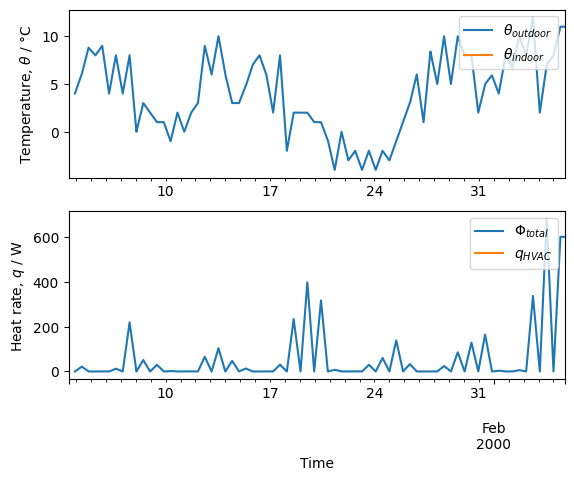

In [764]:
fig, axs = plt.subplots(2, 1)

data[['To', 'θi_exp2']].plot(ax=axs[0],
                            xticks=[],
                            ylabel='Temperature, $θ$ / °C')
axs[0].legend(['$θ_{outdoor}$', '$θ_{indoor}$'],
              loc='upper right')

data[['Φtot', 'q_HVAC']].plot(ax=axs[1],
                              ylabel='Heat rate, $q$ / W')
axs[1].set(xlabel='Time')
axs[1].legend(['$Φ_{total}$', '$q_{HVAC}$'],
             loc='upper right')
plt.show()

> Figure 6. Simulation in free-running with weather data using Euler explicit method of integration. a) Indoor and outdoor temperatures. b) Solar and HVAC heat flow rates.

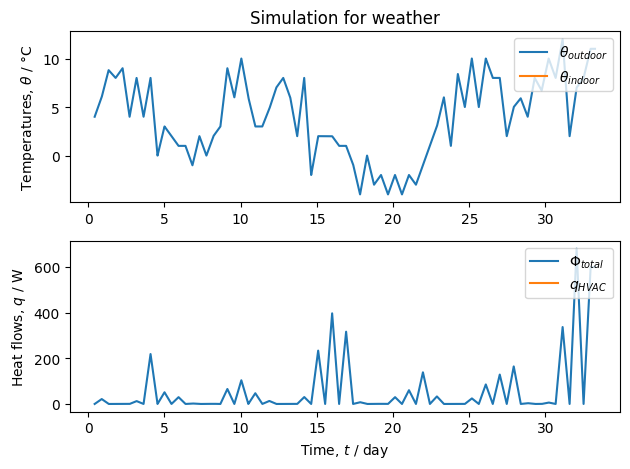

In [765]:
t = dt * np.arange(data.shape[0])   # time vector

fig, axs = plt.subplots(2, 1)
# plot outdoor and indoor temperature
axs[0].plot(t / 3600 / 24, data['To'], label='$θ_{outdoor}$')
axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$θ_{indoor}$')
axs[0].set(ylabel='Temperatures, $θ$ / °C',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600 / 24, data['Φtot'], label='$Φ_{total}$')
axs[1].plot(t / 3600 / 24, q_HVAC, label='$q_{HVAC}$')
axs[1].set(xlabel='Time, $t$ / day',
           ylabel='Heat flows, $q$ / W')
axs[1].legend(loc='upper right')

fig.tight_layout()

> Figure 7. Simulation in free-running with weather data using Euler explicit method of integration. a) Indoor and outdoor temperatures. b) Solar and HVAC heat flow rates.

## Discussion

Interchnage the materials  of the layers of the wall. Discuss the step responses and the simuation for weather. Give arguments for the advantages and the disadvanted of indoor and outdoor insulation.

The time step depends on:

- P-controller gain `Kp`:
    - if $K_p \rightarrow \infty$, then the controller is perfect and the time step needs to be small;
    - if $K_p \rightarrow 0$, then, the controller is ineffective and the building is in free-running.
- Capacities considered into the model:
    - if the capacities of the air $C_a =$ `C['Air']` and of the glass $C_g =$ `C['Glass']` are considered, then the time step is small;
    - if the capacities of the air and of the glass are zero, then the time step is large (and the order of the state-space model is reduced).

The controller models an HVAC system able to heat (when $q_{HVAC} > 0$) and to cool (when $q_{HVAC} < 0$).

## References

1. C. Ghiaus (2013) Causality issue in the heat balance method for calculating the design heating and cooling loads, *Energy* 50: 292-301, https://doi.org/10.1016/j.energy.2012.10.024, open access preprint: [hal-03605823](https://hal.archives-ouvertes.fr/hal-03605823/document)

2. J.A. Duffie, W. A. Beckman, N. Blair (2020) [Solar Engineering of Thermal Processes](https://www.eng.uc.edu/~beaucag/Classes/SolarPowerForAfrica/Solar%20Engineering%20of%20Thermal%20Processes,%20Photovoltaics%20and%20Wind.pdf), 5th ed. John Wiley & Sons, Inc. ISBN 9781119540281

3. [Réglementation Thermique 2005. Méthode de calcul Th-CE.](https://pdfslide.fr/documents/rt2005-methode-de-calcul-th-ce.html) Annexe à l’arrêté du 19 juillet 2006

4. H. Recknagel, E. Sprenger, E.-R. Schramek (2013) Génie climatique, 5e edition, Dunod, Paris. ISBN 978-2-10-070451-4

5. J.R. Howell et al. (2021) Thermal Radiation Heat Transfer 7th edition, ISBN 978-0-367-34707-0, [A Catalogue of Configuration Factors](http://www.thermalradiation.net/indexCat.html)

6. J. Widén, J. Munkhammar (2019) [Solar Radiation Theory](http://www.diva-portal.org/smash/get/diva2:1305017/FULLTEXT01.pdf), Uppsala University

# [Thermal circuits assembling](04AssemblingCircuits.ipynb)

# [Switch between models: heating & cooling and free-running](05SwitchModels.ipynb)

# [Control input: heating & cooling and free-running](06Control_Input.ipynb)

# [Radiation coupled with convection](07Coupled_rad_convection.ipynb)

# [Sensible thermal load in steady-state](08Thermal_load.ipynb)

# [Air flow by ventilation](09Air_flow_ventilation.ipynb)